## Gather NBA Data

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy
##Visualization - (Not needed for INFO 3300)
import matplotlib.pyplot as pyplot
from sklearn.linear_model import LinearRegression

In [2]:
summary_df = pd.DataFrame()

url_iterator = "https://www.basketball-reference.com/leagues/NBA_{year}.html"

for year in range(1980, 2020):
    url = url_iterator.format(year=year)
    with urllib.request.urlopen(url) as response:
        html = response.read().decode('utf-8')
    cleaned_soup = BeautifulSoup(re.sub("<!--|-->","", html)) 
    
##################################### Modified Beautiful Soup

    #Eastern Conference
    eastwins = cleaned_soup.find('table', {'id':'divs_standings_E'})

    #Western Conference
    westwins = cleaned_soup.find('table', {'id':'divs_standings_W'})
    
    #Game_Data for Each Team
    tableStats = cleaned_soup.find('table', {'id':'team-stats-per_game'})
    
    advanced = cleaned_soup.find('table', {'id':'misc_stats'})
    
    
##################################### Retrieve Data

    #Teams
    data3 = westwins.findAll('tr')[2:] 
    data2 = eastwins.findAll('tr')[2:] 
    win_names = [[th.getText() for th in data2[i].findAll('th')] for i in range(len(data2))]
    win_names2 = [[th.getText() for th in data3[i].findAll('th')] for i in range(len(data3))]
   
    #Advanced Stats
    data5 = advanced.findAll('tr')[1:] 
    advanced_data = [[td.getText() for td in data5[i].findAll('td')] for i in range(len(data5))]
    adv_data = list(filter(lambda a: a != [], advanced_data))

    indexes = [0,9,10]

    adv_data = [[i[x] for x in indexes] for i in adv_data]

    #columns
    columnnames = [th.getText() for th in tableStats.findAll('tr')[0].findAll('th')]
    
    #remove rank
    columnnames = columnnames[1:]
    #insert wins and losses
    columnnames.insert(2, "Wins")
    columnnames.insert(3, "Losses")
    columnnames.insert(4, "OEFF")
    columnnames.insert(5, "DEFF")
   
    #get the data-rows and game data   
    data = tableStats.findAll('tr')[1:] 
    game_data = [[td.getText() for td in data[i].findAll('td')] for i in range(len(data))]

    
##################################### Pre-Processing
    
    #Combine East and West Together
    win_names = win_names + win_names2

    dsplit = numpy.asarray(win_names) 
    dsplit = numpy.ndarray.flatten(dsplit)

    #Get rid of Divisions
    dsplit = [e for e in dsplit if e not in ('Atlantic Divison', 'Central Division', 'Southeast Division', 'Northwest Division' 'Midwest Division','Pacific Division', 'Southwest Division')]

    #Get rid of Basketball Reference Formatting and Seeding
    lista = [el.replace('\xa0',' ') for el in dsplit]
    lista = [re.split('[ ]\(\d+\)[ ]', el)[0] for el in lista]


    win_data = [[td.getText() for td in data2[i].findAll('td')][0:2] for i in range(len(data2))]
    win_data2 = [[td.getText() for td in data3[i].findAll('td')][0:2] for i in range(len(data3))]

    win_data = win_data + win_data2

    win_data = list(filter(lambda a: a != [], win_data))
    
    out = list(zip(lista, win_data))
    out = [list(item) for item in out]

    #append wins and losses, advanced data
    for i in game_data:
        for j in out:
            if i[0] == j[0]:
                i.insert(2, j[1][0])
                i.insert(3, j[1][1])
            else:
                pass
            
    #append advanced stats columns     
    for i in game_data:
        for j in adv_data:
            if i[0] == j[0]:
                i.insert(4, j[1])
                i.insert(5, j[2])
            else:
                pass
            
#################################### Append Data to Dataframe


    # Combine both into a data frame
    year_df = pd.DataFrame(game_data, columns=columnnames)
    # Insert Year Column  
    year_df.insert(0, 'Year', year)
    #Take out League Average Statistics
    year_df = year_df.iloc[:-1]

    # Append to dataframe and reiterate (DON'T use index labels)
    summary_df = summary_df.append(year_df, ignore_index=True)

In [10]:
summary_df.head()

,Year,Team,G,Wins,Losses,OEFF,DEFF,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1980,San Antonio Spurs*,82,41,41,108.6,109.0,240.9,47.0,94.4,...,.801,14.1,30.7,44.7,28.4,9.4,4.1,19.4,25.6,119.4
1,1980,Los Angeles Lakers*,82,60,22,109.5,103.9,242.4,47.5,89.9,...,.775,13.2,32.4,45.6,29.4,9.4,6.7,20.0,21.8,115.1
2,1980,Cleveland Cavaliers,82,37,45,106.7,106.4,243.0,46.5,98.1,...,.772,15.9,29.0,45.0,25.7,9.3,4.2,16.7,23.6,114.1
3,1980,New York Knicks,82,39,43,106.5,107.5,241.2,46.4,93.6,...,.747,15.1,28.1,43.2,27.6,10.7,5.6,19.7,26.4,114.0
4,1980,Boston Celtics*,82,61,21,109.4,101.9,242.4,44.1,90.1,...,.779,15.0,30.0,44.9,26.8,9.9,3.8,18.8,24.1,113.5


In [11]:
summary_df.tail()

,Year,Team,G,Wins,Losses,OEFF,DEFF,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1099,2019,Miami Heat,82,39,43,107.3,107.6,240.6,39.6,88.0,...,.695,11.2,35.1,46.3,24.3,7.6,5.5,14.7,20.9,105.7
1100,2019,Chicago Bulls,82,22,60,104.8,113.2,242.7,39.8,87.9,...,.783,8.8,34.1,42.9,21.9,7.4,4.3,14.1,20.3,104.9
1101,2019,New York Knicks,82,17,65,104.5,113.7,241.2,38.2,88.3,...,.759,10.5,34.3,44.7,20.1,6.8,5.1,14.0,20.9,104.6
1102,2019,Cleveland Cavaliers,82,19,63,107.7,117.6,240.9,38.9,87.6,...,.792,10.7,31.9,42.7,20.7,6.5,2.4,13.5,20.0,104.5
1103,2019,Memphis Grizzlies,82,33,49,106.1,108.8,242.4,38.0,84.4,...,.772,8.8,33.0,41.8,23.9,8.3,5.5,14.0,22.0,103.5


## Clean up Data Table, Save into CSV

In [12]:
summary_df.rename(columns={'PF':'PFoul'}, inplace=True)
summary_df = summary_df.convert_objects(convert_numeric=True)


/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [13]:
summary_df.to_csv("NBA_1980.2019.csv")

## Summary Stats for One Team

Getting Data for just 1 Team: Sample Toronto Raptors 

In [14]:
#get all occurences of the Golden State Warriors Stats per Game, including both seasons where they made and missed playoffs
gsw = summary_df[(summary_df['Team']=='Toronto Raptors') | (summary_df['Team']=='Toronto Raptors*' )]
gsw

,Year,Team,G,Wins,Losses,OEFF,DEFF,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PFoul,PTS
413,1996,Toronto Raptors,82,21,61,103.8,111.8,241.8,37.6,80.5,...,0.723,13.1,27.0,40.0,23.5,9.1,6.0,18.8,24.2,97.5
439,1997,Toronto Raptors,82,30,52,104.6,108.0,241.8,35.3,80.9,...,0.720,13.8,27.5,41.3,20.9,8.8,6.3,16.4,23.0,95.5
467,1998,Toronto Raptors,82,16,66,101.2,111.0,243.0,36.2,83.1,...,0.718,14.5,26.2,40.7,21.3,9.4,8.1,16.7,22.6,94.9
497,1999,Toronto Raptors,50,23,27,102.0,103.9,241.5,33.2,78.8,...,0.760,14.2,28.9,43.2,20.7,8.8,6.4,16.0,22.8,91.1
525,2000,Toronto Raptors*,82,45,37,104.7,104.9,240.9,36.3,83.9,...,0.765,13.4,29.9,43.3,23.7,8.1,6.6,13.9,24.3,97.2
542,2001,Toronto Raptors*,82,47,35,105.9,103.4,243.4,37.2,85.0,...,0.747,13.6,30.8,44.5,24.4,7.3,6.3,13.2,21.3,97.6
591,2002,Toronto Raptors*,82,42,40,102.6,103.1,240.9,35.6,82.0,...,0.739,13.6,28.5,42.1,21.7,8.4,5.5,14.3,21.6,91.4
622,2003,Toronto Raptors,82,24,58,100.5,107.0,241.5,34.7,81.3,...,0.718,12.5,28.7,41.2,19.3,7.4,4.8,14.4,21.5,90.9
653,2004,Toronto Raptors,82,33,49,97.0,100.4,243.7,32.4,77.4,...,0.750,10.1,29.5,39.6,19.2,7.4,4.9,14.2,21.3,85.4
660,2005,Toronto Raptors,82,33,49,106.9,108.7,241.5,36.0,81.2,...,0.774,10.3,29.8,40.1,20.4,7.6,3.9,13.3,22.9,99.7


## Descriptive Statistics

In [15]:
summary_df.describe()

,Year,G,Wins,Losses,OEFF,DEFF,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PFoul,PTS
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,...,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,2000.559783,80.722826,40.361413,40.361413,106.523822,106.512319,241.702627,38.752989,83.801268,0.461997,...,0.754239,12.431522,30.256884,42.686141,23.069293,8.062409,5.068388,15.540308,22.321014,101.925996
std,11.313390,5.679342,12.832939,12.833574,3.803055,3.522994,0.840499,3.301491,4.645912,0.021420,...,0.028997,1.968778,2.106117,2.107388,2.620352,1.091054,0.959736,1.829940,2.323730,7.017021
min,1980.000000,50.000000,7.000000,9.000000,92.200000,94.100000,240.000000,30.800000,71.200000,0.401000,...,0.660000,7.600000,24.900000,35.600000,15.600000,5.500000,2.400000,11.200000,16.600000,81.900000
25%,1991.000000,82.000000,31.000000,31.000000,104.000000,104.175000,241.200000,36.300000,80.475000,0.447000,...,0.737000,11.000000,28.900000,41.200000,21.075000,7.300000,4.400000,14.200000,20.600000,96.800000
50%,2001.000000,82.000000,41.000000,40.000000,106.400000,106.700000,241.500000,38.300000,83.500000,0.460500,...,0.755000,12.300000,30.000000,42.700000,22.800000,8.000000,5.000000,15.200000,22.200000,101.400000
75%,2010.000000,82.000000,50.000000,50.000000,109.200000,109.000000,242.100000,41.100000,87.100000,0.476000,...,0.773000,13.800000,31.500000,44.125000,24.900000,8.700000,5.600000,16.600000,23.900000,106.725000
max,2019.000000,82.000000,73.000000,72.000000,115.900000,117.600000,244.900000,48.500000,108.100000,0.545000,...,0.832000,18.500000,40.400000,49.700000,31.400000,12.800000,8.700000,22.800000,29.700000,126.500000


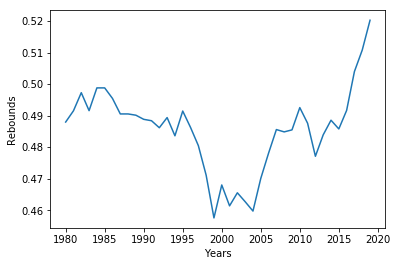

In [16]:
#grab year by year
x_values = summary_df.Year.unique()  

ORB = [summary_df[summary_df['Year']==yr]['2P%'].mean() for yr in x_values]
DRB = [summary_df[summary_df['Year']==yr]['DRB'].mean() for yr in x_values]


y_values = ORB
y_values2 = DRB

pyplot.ylabel("Rebounds")
pyplot.xlabel("Years")

pyplot.plot(x_values, y_values)


In [14]:
ORBstuff = pd.DataFrame(ORB) 

ORBstuff.to_csv("blah.csv")

How the Data was manipulated and saved for the four markers, using ORB as an example